<a href="https://colab.research.google.com/github/elenasoria3/prueba_semantica/blob/main/SpaCy_informationextraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraer conocimiento del texto: Extracción de información con spaCy y Neo4j
https://towardsdatascience.com/extract-knowledge-from-text-end-to-end-information-extraction-pipeline-with-spacy-and-neo4j-502b2b1e0754


In [1]:
!pip install crosslingual-coreference==0.2.3 spacy-transformers==1.1.5 wikipedia neo4j
!pip install --upgrade google-cloud-storage
!pip install transformers==4.18.0
!python -m spacy download en_core_web_sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.17.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.17.0
    Uninstalling transformers-4.17.0:
      Successfully uninstalled transformers-4.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.1.5 requires transformers<4

# Restart runtime

Extracción de información (EI). 
Las cadenas de extracción de información y conocimiento extraen datos estructurados a partir de datos no estructurados, como texto. Internet ofrece abundante información en forma de artículos y otros formatos de contenido.

# Desarrollo de pipeline para IE en SpaCy
[SpaCy](https://spacy.io/) tiene varios plugins para construir una cadena de extracción de información.

## Resolución de coreferencias
Vamos a utilizar el nuevo modelo [Crosslingual Coreference](https://spacy.io/universe/project/crosslingualcoreference) aportado por [David Berenstein](https://www.linkedin.com/in/david-berenstein-1bab11105/) al [SpaCy Universe](https://spacy.io/universe), colección de plugins o complementos de código abierto sencillos de añadir los modelos a nuestro pipeline. Este plugin convierte correferencias entre frases del mismo párrafo a frases simples e independientes. Por ejemplo:
De: Do not forget about Momofuku Ando. He created instant noodles in Osaka.
A:  Do not forget about Momofuku Ando. Momofuku Ando created instant noodles in Osaka.

## Extracción de relaciones
No se va a usar el reconocimiento de entidades nombradas con SpaCy porque vamos a usar un proyecto externo más potente [Rebel](https://github.com/Babelscape/rebel) que reconoce tanto las entidades como las relaciones entre ellas. El modelo Rebel está disponible en Hugginface y en forma de componente SpaCy y se puede probar con [tu propio texto](https://huggingface.co/spaces/Babelscape/rebel-demo).
Sin embargo, el modelo no realiza ninguna vinculación de entidades con conceptos semánticos, por lo que buscaremos entidades en WikiData llamando a su API de búsqueda de entidades.

Existen otros proyectos que hacen esto como [ExtEnd](https://github.com/SapienzaNLP/extend) con un enfoque novedoso para la desambiguación de entidades. También está disponible como demo en Huggingface, así como en forma de componente SpaCy pero al parecer usa versiones de PyTorch distintas que los dos proyectos anteriores.

In [3]:
import spacy
import crosslingual_coreference

# Funciones para la búsqueda en Wikidata de entidades nombradas (se usarán más adelante)

Utilizaremos una versión simplificada de la vinculación de entidades tomando el primer candidato obtenido de la API WikiData. Lo único que tenemos que hacer es incorporar nuestra solución simplificada de enlace de entidades en el pipeline de Rebel. Dado que el componente Rebel no está disponible directamente como proyecto SpaCy Universe, debemos copiar manualmente la definición del componente desde su repositorio.

In [4]:
# https://github.com/Babelscape/rebel/blob/main/spacy_component.py
import requests
import re
import hashlib
from spacy import Language
from typing import List

from spacy.tokens import Doc, Span

from transformers import pipeline

def call_wiki_api(item):
  try:
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={item}&language=en&format=json"
    data = requests.get(url).json()
    # Return the first id (Could upgrade this in the future)
    return data['search'][0]['id']
  except:
    return 'id-less'

def extract_triplets(text):
    """
    Function to parse the generated text and extract the triplets
    """
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})

    return triplets


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)
        self.entity_mapping = {}
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
          Doc.set_extension("rel", default={})

    def get_wiki_id(self, item: str):
        mapping = self.entity_mapping.get(item)
        if mapping:
          return mapping
        else:
          res = call_wiki_api(item)
          self.entity_mapping[item] = res
          return res

    
    def _generate_triplets(self, sent: Span) -> List[dict]:
          output_ids = self.triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]["output_ids"]
          extracted_text = self.triplet_extractor.tokenizer.batch_decode(output_ids[0])
          extracted_triplets = extract_triplets(extracted_text[0])
          return extracted_triplets

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        for triplet in triplets:

            # Remove self-loops (relationships that start and end at the entity)
            if triplet['head'] == triplet['tail']:
                continue

            # Use regex to search for entities
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)

            # Skip the relation if both head and tail entities are not present in the text
            # Sometimes the Rebel model hallucinates some entities
            if not head_span or not tail_span:
              continue

            index = hashlib.sha1("".join([triplet['head'], triplet['tail'], triplet['type']]).encode('utf-8')).hexdigest()
            if index not in doc._.rel:
                # Get wiki ids and store results
                doc._.rel[index] = {"relation": triplet["type"], "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(triplet['tail'])}}

    def __call__(self, doc: Doc) -> Doc:
        for sent in doc.sents:
            sentence_triplets = self._generate_triplets(sent)
            self.set_annotations(doc, sentence_triplets)
        return doc

La función set_annotations se encarga de almacenar los resultados en el objeto Doc de SpaCy (estructura que usa SpaCy para guardar todo lo analizado de un texto). Ignoramos todas las relaciones que empiezan y terminan en la misma entidad. A continuación, buscamos las entidades de inicio y fin de cada relación en el texto.
Por último, utilizamos la API de WikiData para asignar las entidades extraídas a los identificadores de WikiData. Es una versión simplificada de la desambiguación y vinculación de entidades, podría funcionar mejor con ExtEnd en el caso de solucionar compatibilidades, no todas las librerías son compatibles entre sí.

En el siguiente código creamos dos pipelines SpaCy, una para la resolución de coreferencias y otra para la extracción de relaciones y la vinculación de entidades. Se desabilitan procesos que SpaCy hace de forma predeterminada y que se va a hacer con otra librería como el NER o que no se van a usar y ocuparía tiempo.
También se indican los hiperparámetros para la ejecución del algoritmo y el modelo entrenado que usa.

In [5]:
DEVICE = -1 # Number of the GPU, -1 if want to use CPU

# Add coreference resolution model
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": DEVICE})

# Define rel extraction model

rel_ext = spacy.load('en_core_web_sm', disable=['ner', 'lemmatizer', 'attribute_rules', 'tagger'])
rel_ext.add_pipe("rebel", config={
    'device':DEVICE, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )



models/crosslingual-coreference/minilm/model.tar.gz: 358490KB [00:09, 36229.31KB/s]                            
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/225M [00:00<?, ?B/s]

Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-st

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344 [00:00<?, ?B/s]

In [6]:
input_text = """Albert Einstein was a German-born theoretical physicist, widely acknowledged to be one of the greatest and most influential physicists of all time. Einstein is best known for developing the theory of relativity, but he also made important contributions to the development of the theory of quantum mechanics. 
Relativity and quantum mechanics are the two pillars of modern physics. 
His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been dubbed the world's most famous equation.
His work is also known for its influence on the philosophy of science.
He received the 1921 Nobel Prize in Physics "for his services to theoretical physics, and especially for his discovery of the law of the photoelectric effect", a pivotal step in the development of quantum theory. 
His intellectual achievements and originality resulted in Einstein becoming synonymous with genius.
In 1905, a year sometimes described as his annus mirabilis ('miracle year'), Einstein published four groundbreaking papers.
These outlined the theory of the photoelectric effect, explained Brownian motion, introduced special relativity, and demonstrated mass-energy equivalence.
Einstein thought that the laws of classical mechanics could no longer be reconciled with those of the electromagnetic field, which led him to develop his special theory of relativity. 
He then extended the theory to gravitational fields; he published a paper on general relativity in 1916, introducing his theory of gravitation. 
In 1917, he applied the general theory of relativity to model the structure of the universe.
He continued to deal with problems of statistical mechanics and quantum theory, which led to his explanations of particle theory and the motion of molecules.
He also investigated the thermal properties of light and the quantum theory of radiation, which laid the foundation of the photon theory of light.
However, for much of the later part of his career, he worked on two ultimately unsuccessful endeavors. 
First, despite his great contributions to quantum mechanics, he opposed what it evolved into, objecting that "God does not play dice".
Second, he attempted to devise a unified field theory by generalizing his geometric theory of gravitation to include electromagnetism.
As a result, he became increasingly isolated from the mainstream of modern physics.
Einstein was born in the German Empire, but moved to Switzerland in 1895, forsaking his German citizenship the following year. 
In 1897, at the age of 17, he enrolled in the mathematics and physics teaching diploma program at the Swiss Federal polytechnic school in Zürich, graduating in 1900.
In 1901, he acquired Swiss citizenship, which he kept for the rest of his life, and in 1903 he secured a permanent position at the Swiss Patent Office in Bern. 
In 1905, he was awarded a PhD by the University of Zurich. In 1914, Einstein moved to Berlin in order to join the Prussian Academy of Sciences and the Humboldt University of Berlin.
In 1917, Einstein became director of the Kaiser Wilhelm Institute for Physics; he also became a German citizen again, this time Prussian.
In 1933, while Einstein was visiting the United States, Adolf Hitler came to power in Germany. 
Einstein, as a Jew, objected to the policies of the newly elected Nazi government; he settled in the United States and became an American citizen in 1940.
On the eve of World War II, he endorsed a letter to President Franklin D. Roosevelt alerting him to the potential German nuclear weapons program and recommending that the US begin similar research. 
Einstein supported the Allies but generally denounced the idea of nuclear weapons."""

coref_text = coref(input_text)._.resolved_text

doc = rel_ext(coref_text)

for value, rel_dict in doc._.rel.items():
    print(f"{value}: {rel_dict}")

/usr/local/lib/python3.8/dist-packages/allennlp/modules/token_embedders/pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


4fb897484e0d8ce7ac072322e6104d7cffb34331: {'relation': 'field of work', 'head_span': {'text': 'Albert Einstein', 'id': 'Q937'}, 'tail_span': {'text': 'theoretical physicist', 'id': 'Q19350898'}}
7493cd419ec9eeba3c093cc085b5730ee24a1e04: {'relation': 'notable work', 'head_span': {'text': 'Albert Einstein', 'id': 'Q937'}, 'tail_span': {'text': 'theory of relativity', 'id': 'Q43514'}}
9efe24d302d9c7f9a90f9d7b0abc80b0e344df7c: {'relation': 'notable work', 'head_span': {'text': 'Albert Einstein', 'id': 'Q937'}, 'tail_span': {'text': 'quantum mechanics', 'id': 'Q944'}}
0664ffe859582eeb3dd3018d0d5336c66f27c47e: {'relation': 'discoverer or inventor', 'head_span': {'text': 'theory of relativity', 'id': 'Q43514'}, 'tail_span': {'text': 'Albert Einstein', 'id': 'Q937'}}
dd4fa4898715ae35765a1bbf7b0cd7c20b3dc2b6: {'relation': 'creator', 'head_span': {'text': 'quantum mechanics', 'id': 'Q944'}, 'tail_span': {'text': 'Albert Einstein', 'id': 'Q937'}}
84d0be0299e6f3885c807468a504f808fe6f38e3: {'relati

El modelo de Rebel establece todas las referencias encontradas en el texto con sus conceptos en la Wikipedia. Puede tardar bastante en función del tamaño del mismo.
# Almacenamiento de los resultados del proceso de extracción de información
Representamos las relaciones encontradas entre entidades en una base de datos de grafos.
Usamos Neo4j pero podría hacerse con otras de similar funcionamiento.
Para ejecutar el siguiente código hay que crear un [proyecto en blanco en la Sandbox de Neo4j](https://sandbox.neo4j.com/?usecase=blank-sandbox) y copiar las credenciales de acceso al código. Se pueden encontrar desplegando con la fecha de la derecha las propiedades del proyectol en la pestaña Connection details de donde obtener la Bolt URL, username y password.

In [7]:
import pandas as pd
import wikipedia
from neo4j import GraphDatabase

# Estas tres variables deben cambiar a la sesión del proyecto de Neo4J creada por cada uno
host = 'bolt://3.236.196.59:7687'
user = 'neo4j'
password = 'writers-cements-reconfiguration'
driver = GraphDatabase.driver(host,auth=(user, password))

import_query = """
UNWIND $data AS row
MERGE (h:Entity {id: CASE WHEN NOT row.head_span.id = 'id-less' THEN row.head_span.id ELSE row.head_span.text END})
ON CREATE SET h.text = row.head_span.text
MERGE (t:Entity {id: CASE WHEN NOT row.tail_span.id = 'id-less' THEN row.tail_span.id ELSE row.tail_span.text END})
ON CREATE SET t.text = row.tail_span.text
WITH row, h, t
CALL apoc.merge.relationship(h, toUpper(replace(row.relation,' ', '_')),
  {},
  {},
  t,
  {}
)
YIELD rel
RETURN distinct 'done' AS result;
"""


def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

def store_wikipedia_summary(page):
  try:
    input_text = wikipedia.page(page).summary
    coref_text = coref(input_text)._.resolved_text
    doc = rel_ext(coref_text)
    params = [rel_dict for value, rel_dict in doc._.rel.items()]
    run_query(import_query, {'data': params})
  except Exception as e:
    print(f"Couldn't parse text for {page} due to {e}")


Con el siguiente código se van a convertir las entidades semánticamente anotadas y sus relaciones a instrucciones en lenguaje Cypher que se almacenan en la instancia de Neo4j creada en la nube.
Volviendo a la pestaña de Neo4j, se pulsa en Open, a continuación en el primer icono de la esquina superior izquierda, a continuación en la relación "*" (todas) y en el icono del grafo para ver la repreesntación visual.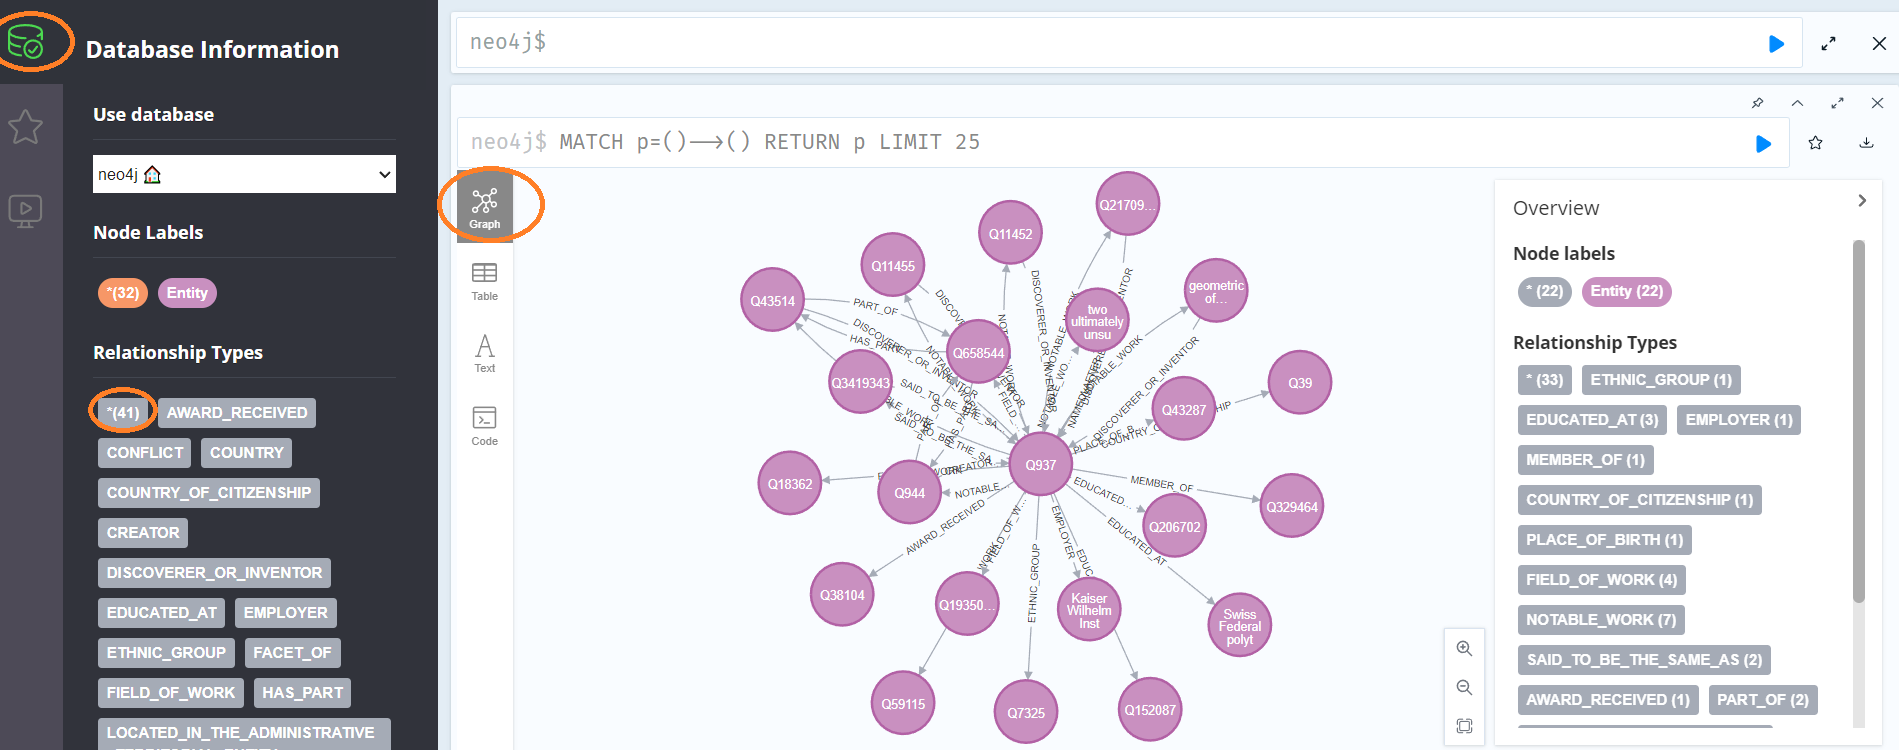

In [8]:
params = [rel_dict for value, rel_dict in doc._.rel.items()]
run_query(import_query, {'data': params})

,result
0,done


Investigad la interfaz pulsando en las entidades, en las relaciones descubriendo el [lenguaje Cypher](https://neo4j.com/developer/cypher/) para hacer consultas, tratad de [crear vuestras propias consultas](https://graphacademy.neo4j.com/courses/cypher-fundamentals/) para inferir conocimiento, como por ejemplo la ciudadanía de todas las entidades que tengan esta relación:
`MATCH p=()-[r:COUNTRY_OF_CITIZENSHIP]->() RETURN p`

Todo el proceso anterior ha partido de un texto propio pero también se puede obtener directamente de fuentes online como la misma Wikipedia, por ejemplo a partir de la búsqueda de conceptos en la Wikipedia obtenemos su texto descriptivo y sus correspondientes relaciones, en esta caso a partir de nombres del resto de la familia de Einstein (puede tardar tiempo).
Puede que el grafo no muestre los nuevos nodos y relaciones del nuevo conocimiento agregado, la razón es que el código Cypher predeterminado al pusar en el icono para ver el grafo genera la siguiente consulta, prueba a cambiar el 25 por un valor superior y busca la nueva información agregada.

`MATCH p=()-->() RETURN p LIMIT 25`

También se puede probar [Neo4j Bloom](https://neo4j.com/product/bloom/) como herramienta de exporación visual rápida sin requisitos de conocimiento de Cypher, al igual que [NEuler](https://neo4j.com/developer/graph-data-science/neuler-no-code-graph-algorithms/) como interfaz de usuario sin código que ayuda a familiarizarse con la biblioteca Neo4j Graph Data Science Library.
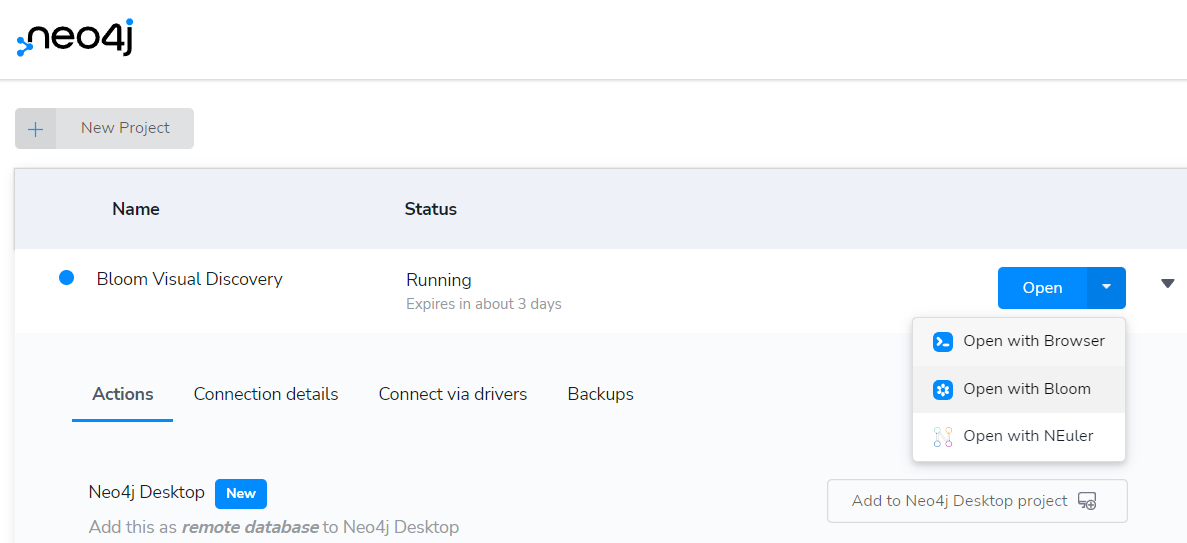


In [9]:
ladies = ["Hans Albert Einstein", "Eduard Einstein", "Lieserl Einstein", "Elsa Einstein", "Mileva Marić"]
# Eduard Einstein da error porque no tiene entrada propia en la Wikipedia en inglés.

for l in ladies:
  print(f"Parsing {l}")
  store_wikipedia_summary(l)

Parsing Hans Albert Einstein
Parsing Eduard Einstein
Couldn't parse text for Eduard Einstein due to Page id "edward einstein" does not match any pages. Try another id!
Parsing Lieserl Einstein
Parsing Elsa Einstein
Parsing Mileva Marić


# Enriquecer el gráfico
Ya que hemos mapeado nuestras entidades a los ids de WikiData, podemos utilizar la API de WikiData para enriquecer nuestro grafo y almacenar en Neo4j con la ayuda de la librería APOC, que nos permite llamar a APIs web y almacenar los resultados en la base de datos de grafos.
Para poder llamar a la API de WikiData, es necesario tener un conocimiento básico de la sintaxis SPARQL.
Ejecutando la siguiente consulta, añadimos los nodos Class al grafo y los vinculamos con las entidades apropiadas.

**NO TERMINA DE FUNCIONAR Y DEBO PUBLICAR LA TAREA**

In [10]:
sparqlQuery = """
CALL apoc.periodic.iterate("
  MATCH (e:Entity)
  WHERE e.id STARTS WITH 'Q'
  RETURN e
","
  // Prepare a SparQL query
  WITH 'SELECT * WHERE{ ?item rdfs:label ?name . filter (?item = wd:' + e.id + ') filter (lang(?name) = \\\"en\\\") ' +
     'OPTIONAL {?item wdt:P31 [rdfs:label ?label] .filter(lang(?label)=\\\"en\\\")}}' AS sparql, e
  // make a request to Wikidata
  CALL apoc.load.jsonParams(
    'https://query.wikidata.org/sparql?query=' + 
      sparql,
      { Accept: 'application/sparql-results+json'}, null)
  YIELD value
  UNWIND value['results']['bindings'] as row
  SET e.wikipedia_name = row.name.value
  WITH e, row.label.value AS label
  MERGE (c:Class {id:label})
  MERGE (e)-[:INSTANCE_OF]->(c)
  RETURN distinct 'done'", {batchSize:1, retry:1})
"""
run_query(sparqlQuery)

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,59,59,9,0,59,59,0,{'Server returned HTTP response code: 400 for ...,"{'total': 59, 'committed': 0, 'failed': 59, 'e...","{'total': 59, 'committed': 0, 'failed': 59, 'e...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


# Conclusiones
SpaCy tiene muchos proyectos de código abierto a su alrededor aunque algunos pueden ser imcompatibles entre si y resultar complicado combinarlos en un único pipeline, razón por la que se han usado dos pipelines en este proyecto, uno para la resolución de coreferencias y otro para la extracción de relaciones y la vinculación de entidades.

En cuanto a los resultados del proceso IE, Rebel funciona muy bien en muchos conjuntos de datos de PLN, así que no es una gran sorpresa que los resultados sean tan buenos. El único punto débil de mi aplicación es el paso Entity Linking. Como ya he dicho, probablemente sería muy beneficioso añadir algo como la biblioteca ExtEnd para una desambiguación y vinculación de entidades más precisas.